<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/Week7_studentizedResiduals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studentized Residuals, outlier detection, and Cook's Distance


We are considering the resgression model

$$Y = Xb + \epsilon$$ 

Where $X$ is an $N \times p$ data matrix of $N$ observed values of $p$ prediction variable (or features), 
$\epsilon$ is a vector of IID draws from $\mathcal{N}(0,\sigma^2_{\epsilon})$ and $Y$ is the vector of $N$ observed values of the respones or target variable.


The estimated coefficients are given by 

$\hat{b} = (X^TX)^{-1}X^TY$.

The estimated values of $\hat{Y} = X \hat{b} = H Y$ where 

$H = X(X^TX)^{-1}X^T$ is called the hat matrix.


We noted in the last video that the $\mathrm{Var}(\hat{Y}_i) = \sigma^2_{\epsilon}H_{i,i}$ and that $H_{i,i}$ is called the leverage of the $i$th observation.



## Estimated Residuals

We now take a look at the estimated residuals $\hat{\epsilon}_i = Y_i - \hat{Y}_i$

While the "true" residuals are IID, this is not the case for the estimated residuals.  We can see this as follows.  (Fixing $X$)


$$\mathrm{Cov}(\hat{\epsilon}) = \mathrm{Cov}( Y - \hat{Y})\\
= \mathrm{Cov}( I_NY - HY)\\
=\mathrm{Cov}\left( (I_N - H)Y\right) \\
=(I_N - H) \mathrm{Cov}(Y)(I_N - H)^T\\
=\sigma_{\epsilon}^2(I_N - H) (I_N - H)^T \\
=\sigma_{\epsilon}^2(I_N - 2H + HH^T)\\
=\sigma_{\epsilon}^2(I_N - H) $$

Specifically then, for a given observation $i$,

$$\mathrm{Var}(\hat{\epsilon}_i) = \sigma_{\epsilon}^2 (1- H_{i,i})$$


This will vary with the leverage. High leverage pointss will have smaller variance in the residuals (which makes sense since the true value of $Y$ is a heavy influencer of the estimate).





Now, we don't know the true value of $\sigma_{\epsilon}$, we have to use the estimated value $\hat{\sigma_{\epsilon}}$


How can we tell if one of our residuals is "large" in the sense that it too "far" away from zero (under the model)? We look at the ratio

$$\frac{\hat{\epsilon}_i}{\hat{\sigma_{\epsilon}}\sqrt{1-H_{i,i}}}$$

This will distributed with a T distribution of $N - p -1$ degree freedom (or $N -p-2$ if there is an intercept).   Hence, we look for outliers wrt to that distribution.

The valule $\frac{\hat{\epsilon}_i}{\hat{\sigma_{\epsilon}}\sqrt{1-H_{i,i}}}$ is called the internally studentized residual.


There is one issue however. An extreme outlier will exaggrate $\hat{\sigma_{\epsilon}}$ and potentially make the internally studentized residual smaller than it should be.  A work-around for this is to use the *externally studentized residual*.  It it is given by

$$\frac{\hat{\epsilon}_i}{\hat{\sigma}_{\epsilon,-i}\sqrt{1-H_{i,i}}}$$


Where  

$$\hat{\sigma}^2_{\epsilon,-i} = \frac{1}{N-p - 1}\sum_{k\neq i} \hat{\epsilon}_k^2$$ 

(or dividing by $N -p -2$ if there is an intercept).
 



### Example

We construct example with $N = 30$ sample points $p =2$ features.  We will just take the $X$ values as being uniform on $[0,10]$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sm


In [ ]:
sigma_e = 4
b = np.array([1,5])
X = np.random.uniform(high =10, size = [30,2])
Y = X@b + np.random.normal(scale = sigma_e, size = 30)

Now we replace the last entry of $Y$ with an outlier.

In [ ]:
 Y[-1] = (X@b)[-1] + 6* sigma_e

Before proceeding, we not that just looking at the $Y$ data alone, nothing appears to be amiss.

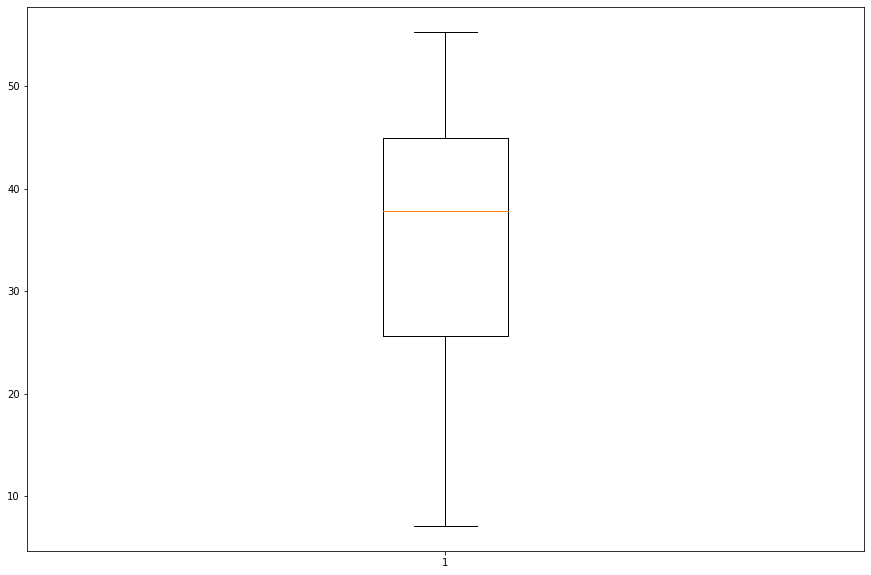

In [ ]:
plt.figure(figsize = (15,10))

plt.boxplot(Y)

plt.show()

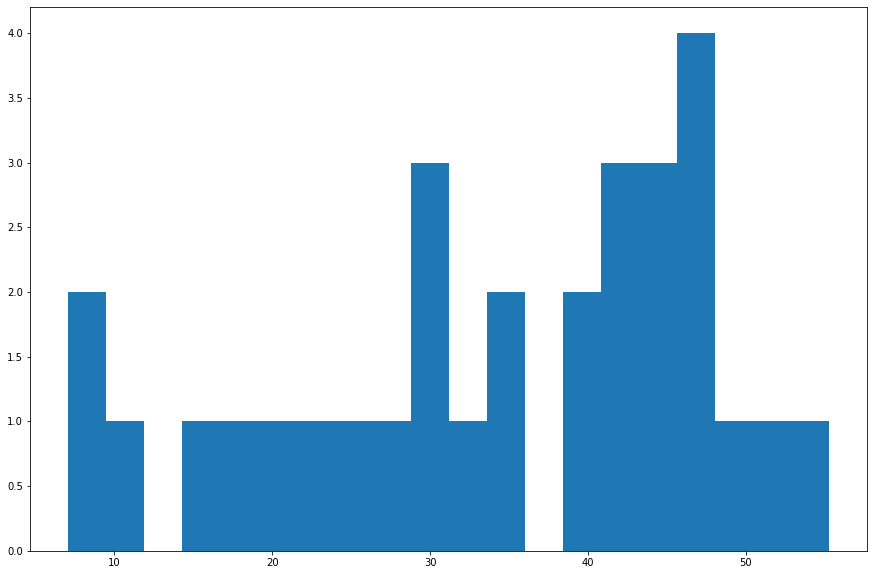

In [ ]:
plt.figure(figsize = (15,10))

plt.hist(Y, bins = 20)

plt.show()

We calculate $H, \hat{Y}, \hat{\epsilon}$ and $\hat{\sigma}_{\epsilon}^2$

In [ ]:
H = X@np.linalg.pinv(X)

Yhat = H@Y

epsilonhat = Y - Yhat

sigma_est = np.sqrt(np.sum(epsilonhat**2)/(30-2-1))

In [ ]:
# Note that it's the estimite of sigma is too big due to the outlier most likely
sigma_est

6.0872078303789126

Now we internally studentize anyway

In [ ]:
resid_st_int = epsilonhat/(sigma_est*np.sqrt(1-np.diag(H)))

In [ ]:
resid_st_int

array([-0.04413698, -0.25229464, -0.23430893, -0.84028411, -0.53753297,
        0.11130722,  0.29783355, -0.84975184, -0.42262822, -0.17860705,
        0.08797416, -0.67156878, -1.44688054,  0.0396709 , -1.00512525,
        1.15932328, -1.14944721,  0.33616968,  1.51981246, -0.20479985,
        1.06595817, -0.87228041,  0.01249016, -0.09489484,  0.13914424,
        0.7936457 ,  0.47019546, -0.59784636,  0.42475535,  3.77815642])

We can then apply the t distribution to get individuala $p$ values. But we must be carefull in interpreting these.

In [ ]:
ss.t.sf(abs(resid_st_int), df = 27)*2

array([9.65120026e-01, 8.02724069e-01, 8.16512851e-01, 4.08128835e-01,
       5.95302578e-01, 9.12196055e-01, 7.68109996e-01, 4.02935374e-01,
       6.75913443e-01, 8.59579697e-01, 9.30546476e-01, 5.07564009e-01,
       1.59441461e-01, 9.68647389e-01, 3.23760051e-01, 2.56474829e-01,
       2.60452109e-01, 7.39341557e-01, 1.40183050e-01, 8.39264591e-01,
       2.95882231e-01, 3.90746652e-01, 9.90126392e-01, 9.25099127e-01,
       8.90368868e-01, 4.34321595e-01, 6.41991318e-01, 5.54924344e-01,
       6.74380864e-01, 7.93543837e-04])

We have observed $30$ points, so we make the Bonferroni adjustment by multiplying the p-values by $30$

In [ ]:
30*ss.t.sf(abs(resid_st_int), df = 27)*2  #note that values larger than 1 are just 1

array([2.89536008e+01, 2.40817221e+01, 2.44953855e+01, 1.22438650e+01,
       1.78590773e+01, 2.73658817e+01, 2.30432999e+01, 1.20880612e+01,
       2.02774033e+01, 2.57873909e+01, 2.79163943e+01, 1.52269203e+01,
       4.78324384e+00, 2.90594217e+01, 9.71280154e+00, 7.69424488e+00,
       7.81356327e+00, 2.21802467e+01, 4.20549150e+00, 2.51779377e+01,
       8.87646692e+00, 1.17223996e+01, 2.97037918e+01, 2.77529738e+01,
       2.67110660e+01, 1.30296478e+01, 1.92597395e+01, 1.66477303e+01,
       2.02314259e+01, 2.38063151e-02])

And we see that we have successfully detected out outlier even though we used the interal studentized residuals.

Fortunately, there is software that does this for and uses the external studentized residuals. Outlier_test() from statsmodels is an example.

In [ ]:
model = sm.OLS(Y, X)
result = model.fit()
result.outlier_test()

array([[-4.41385728e-02,  9.65118769e-01,  1.00000000e+00],
       [-2.52592558e-01,  8.02496201e-01,  1.00000000e+00],
       [-2.34547513e-01,  8.16329538e-01,  1.00000000e+00],
       [-8.51491548e-01,  4.01985636e-01,  1.00000000e+00],
       [-5.40432478e-01,  5.93329359e-01,  1.00000000e+00],
       [ 1.11332770e-01,  9.12175989e-01,  1.00000000e+00],
       [ 2.98324000e-01,  7.67739705e-01,  1.00000000e+00],
       [-8.61347678e-01,  3.96631827e-01,  1.00000000e+00],
       [-4.24033112e-01,  6.74901071e-01,  1.00000000e+00],
       [-1.78712659e-01,  8.59497582e-01,  1.00000000e+00],
       [ 8.79867732e-02,  9.30536547e-01,  1.00000000e+00],
       [-6.77248940e-01,  5.04010063e-01,  1.00000000e+00],
       [-1.50646098e+00,  1.43560286e-01,  1.00000000e+00],
       [ 3.96720607e-02,  9.68646475e-01,  1.00000000e+00],
       [-1.02447470e+00,  3.14702774e-01,  1.00000000e+00],
       [ 1.18930220e+00,  2.44675037e-01,  1.00000000e+00],
       [-1.17864711e+00,  2.48821994e-01

The first column is the statistic.  The second is the p-value not adjusted.  The last column is the Bonferroni adjussted p-value.  Not that they cap the latter at 1.   

## Cook's Distance

We have discussed regression diagnostics relating to the data.

1. VIF, which measures how variable the coefficient estimate is comnpared to if the other features were not included.  It is a measure of colinearity.

2. Leverage.  It measures the influence an individual obsevation of $Y_i$ has on it's own regressed value $\hat{Y}_i$

3. Studentized residuals.  These can help us detect outlier $Y$ values.


What we seek now is a measure of how much an individual observation $i$ has on *all* of the predicted values $\hat{Y}_j$.  This measure will be called Cook's distance. 



The definition of Cook's distance is simple an intuitive:

We first define $\hat{Y}_j(-i)$ to be the estimated value of $Y_j$ when the $i$th data point is removed from the data set. 

Then, for the $i$'th data point, we have

$$cd_i = \frac{1}{p\hat{\sigma}_{\epsilon}^2} \sum_{j=1}^N \left(\hat{Y}_j - \hat{Y}_j(-i)\right)^2$$


When assesssing these values, one typically visually looks see if one stands out from the others.  If so, it suggests the the single data point may have unduo influnce on the result.  

Unsurprisingly, statsmodels will calculatee this for us.  

In [ ]:
influence_info = result.get_influence()

cd = influence_info.cooks_distance[0]  # we ignore the second elemnt of the output.

print(cd)

[5.03861261e-05 6.55510294e-04 3.87820280e-03 7.71088061e-02
 1.38119293e-03 1.04826342e-03 3.02504167e-03 3.18358531e-02
 4.27332780e-03 2.45697993e-04 2.20979651e-04 2.25533791e-02
 4.65093507e-02 2.14639804e-05 3.69487318e-02 5.88285628e-02
 3.20556641e-02 4.65160206e-03 5.00368744e-02 7.90590188e-05
 4.75556409e-02 4.84223125e-02 2.36381344e-06 5.14730160e-04
 1.45342399e-03 3.14144859e-02 9.46095457e-03 9.99084805e-03
 9.32509848e-03 2.63707581e-01]


Let's plot this to see if one stands out.

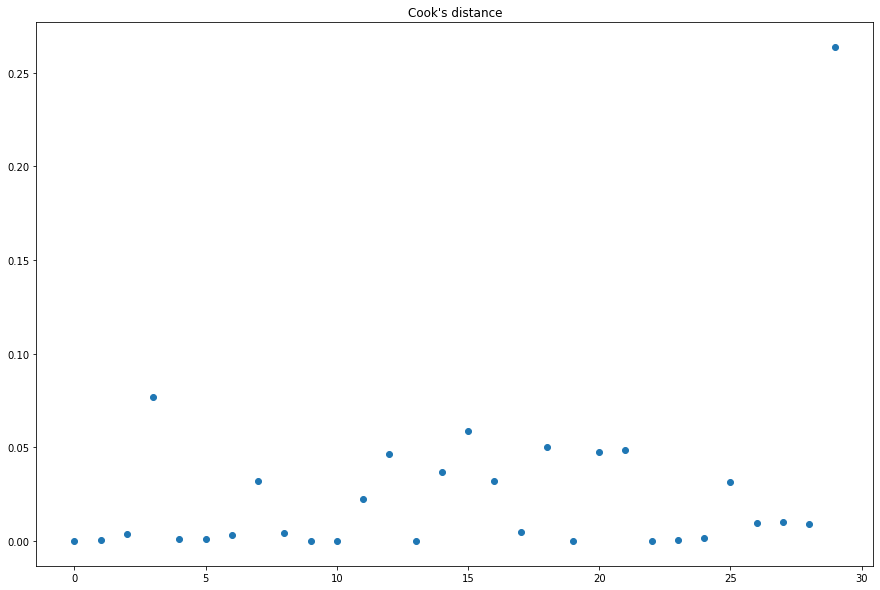

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(cd, 'o')

plt.title("Cook's distance")
plt.show()

We see that the last data point is influencing the results more than any other point.  The point was out outlier.


Incidentally, the influence_info object contains a lot of useful information.

In [ ]:
influence_info.summary_table()

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,40.256832469454174,40.51904326034125,5.0386126067739976e-05,-0.044946900888006874,0.04751175623812486,-0.010038538346566196,-0.044138572826496796,-0.009858004603821774
1.0,20.246988531596468,21.767731009406724,0.0006555102942246163,-0.25692428372286535,0.019474138563369832,-0.0362080182894512,-0.25259255771235045,-0.0355975535550908
2.0,21.968501287045182,23.306553009607534,0.0038782028037176977,-0.2386085372177442,0.1199003384506944,-0.08807045819930424,-0.2345475130426596,-0.08657153337444867
3.0,46.96511351677228,51.613919470229185,0.07710880613588221,-0.8557034507542417,0.1739729333728153,-0.3927055032359038,-0.8514915482488122,-0.3907725470330074
4.0,8.560798573380428,11.817894466476808,0.0013811929287776982,-0.5473967817682297,0.009134704025283224,-0.05255840425236859,-0.5404324779657074,-0.05188972532187342
5.0,24.81797160475708,24.189741792154027,0.0010482634208866402,0.11334972866058354,0.14028575676748287,0.04578784600495289,0.11133277008143956,0.04497309161681708
6.0,40.85050452030201,39.09436004365119,0.0030250416709650995,0.3032988373366375,0.06171018767009517,0.0777822816708934,0.29832400036451,0.07650646349094006
7.0,29.02046313847581,33.98626667904547,0.03183585313774102,-0.8653449165343913,0.07836580090560878,-0.25233253114785265,-0.8613476778177996,-0.25116694579143867
8.0,35.50101071892362,38.016263022834536,0.004273327801227787,-0.4303835125250398,0.04410571022465456,-0.09244812384497358,-0.4240331117450461,-0.09108403200435058


31.237978878342915